# Imports


In [17]:
import numpy as np
import pandas as pd
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn import mixture
from sklearn.mixture import GaussianMixture
from __future__ import print_function
from sklearn.manifold import TSNE
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns
import umap
from matplotlib.pyplot import figure
from IPython.display import display, Markdown

# Functions


In [77]:
def UMAP_pipeline(data, i, components=50):
    
    name = "umap"+str(i)+".jpg"
    number_samples = data.shape[0]
    umap_components = min(components,number_samples//8)
    number_neighbors = 13
    umap_o = umap.UMAP(n_neighbors=number_neighbors, min_dist=0.25, n_components=umap_components)
    umap_data = umap_o.fit_transform(data)
    
    figure(figsize=(8, 6), dpi=60)
    plt.scatter(umap_data[:, 0], umap_data[:, 1])
    plt.xlabel("Component 1")
    plt.ylabel("Component 2")
    plt.title('UMAP');
    plt.savefig(name)
    plt.show()
    return umap_components

def PCA_pipeline(data, i, variance_th = 0.9):
    
    name = "pca_var"+str(i)+".jpg"
    pca = PCA()
    pca_data = pd.DataFrame(pca.fit_transform(data))
    pca_data.head()

    s=np.zeros(200)
    pca_components=0
    for k in range(len(pca.explained_variance_ratio_)):
        if k==0:
            s[0]=pca.explained_variance_ratio_[0]
        else:
            s[k]=s[k-1]+pca.explained_variance_ratio_[k]
            if s[k]>variance_th and pca_components==0:
                pca_components=k
                
    figure(figsize=(8, 6), dpi=60)            
    plt.plot(s, marker='o', c='b')
    plt.xlabel('Number of dimensions')
    plt.ylabel('PCA explained variance');
    plt.savefig(name)
    plt.show()
    
    print("PCA needs "+str(pca_components)+" components to reach "+str(variance_th*100)+  "% of the total variance")
    pca=PCA(n_components=pca_components)
    pca.fit(data)
    pca_data = pd.DataFrame(pca.transform(data))
    
    name = "pca"+str(i)+".jpg"
    figure(figsize=(8, 6), dpi=60)
    plt.scatter(pca_data[0], pca_data[1])
    plt.xlabel("Component 1")
    plt.ylabel("Component 2")
    plt.title('PCA');
    plt.savefig(name)
    plt.show()
    
    return pca_components, pca_data

def TSNE_pipeline(data, i, components = 2):
    
    name = "tsne"+str(i)+".jpg"
    tsne = TSNE(n_components = components, method='exact')
    tsne_data = tsne.fit_transform(data)
    
    figure(figsize=(8, 6), dpi=60)
    plt.scatter(x=tsne_data[:,0], y=tsne_data[:,1])
    plt.xlabel("Component 1")
    plt.ylabel("Component 2")
    plt.title('TSNE');
    plt.savefig(name)
    plt.show()
    return tsne_data

def BIC_calculation (data, i, mode_dim):
    
    name = "bic"+str(i)+" "+str(mode_dim)+".jpg"
    modes = ['full', 'tied', 'diag', 'spherical']
    n_components = np.arange(1, 10)
    best_mode = {modes[0] : [1, 0], modes[1] : [1, 0], modes[2] : [1, 0], modes[3] : [1, 0]}
    figure(figsize=(8, 6), dpi=60)
    for mode in modes:
        models = [mixture.GaussianMixture(n, covariance_type=mode, random_state=0).fit(data) for n in n_components]
        plt.plot(n_components, [m.bic(data) for m in models], label='BIC - '+str(mode))
        plt.legend(loc='best')
        plt.xlabel('number of components')
        plt.title('BIC criterion for each GMM - '+str(mode_dim));

        bic=np.zeros(10)
        clust=1
        sc=0
        i=0
        for m in models:
            i+=1
            bic[i]=m.bic(data)
            if i==1:
                sc=m.bic(data)
            elif sc>m.bic(data):
                clust=i
                sc=m.bic(data)
        best_mode[mode][0] = clust
        best_mode[mode][1] = sc
        #print(sc)
    plt.savefig(name)
    plt.show()

    sorted_modes = sorted(best_mode.items(), key=lambda x: x[1][1], reverse=False)
    return sorted_modes

def GMM_clustering(data, i, mode):
    
    name = "clusters"+str(i)+" "+str(mode)+".jpg"
    best_mode = BIC_calculation(data, i, mode)
    gaus_mode = next(iter(best_mode))
    print("---"+str(mode)+" - Best BIC score: "+str(gaus_mode[1][1])+" for "+str(gaus_mode[0])+" mode and for "+str(gaus_mode[1][0])+" clusters")
    gmm = mixture.GaussianMixture(n_components=gaus_mode[1][0], covariance_type=gaus_mode[0], random_state=0).fit(data)
    labels = gmm.predict(data)
    
    figure(figsize=(8, 6), dpi=55)
    if mode == "PCA":
        plt.scatter(data[0], data[1], c=labels, s=40, cmap='viridis')
    else :
        plt.scatter(data[:,0], data[:,1], c=labels, s=40, cmap='viridis')
    plt.xlabel('Component 1')
    plt.ylabel('Component 2')
    plt.title('Clustering with '+str(gaus_mode[1][0])+' clusters and '+str(gaus_mode[0])+ ' gaussian mode- '+str(mode));
    plt.savefig(name)
    plt.show()
    
    name = "posterior"+str(i)+" "+str(mode)+".jpg"
    figure(figsize=(8, 6), dpi=55)
    posteriors=gmm.predict_proba(data).sum(axis=0)/data.shape[0]
    plt.xlabel("Clusters")
    plt.ylabel("Posterior probability")
    plt.title("Posterior probability for every cluster - "+str(mode))
    plt.ylim([0,1])
    plt.bar(range(1, len(posteriors)+1), posteriors, tick_label=range(1,len(posteriors)+1), color='darkorchid', width=0.5) 
    plt.savefig(name)
    plt.show()


# Main loop

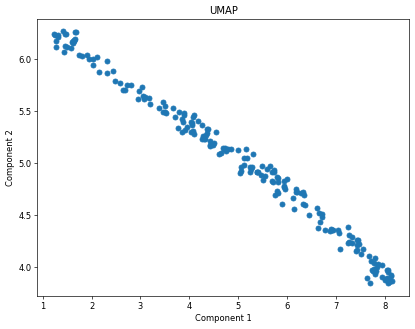

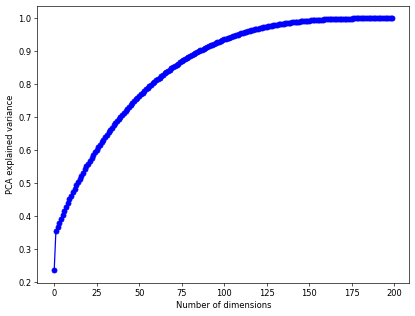

PCA needs 86 components to reach 90.0% of the total variance


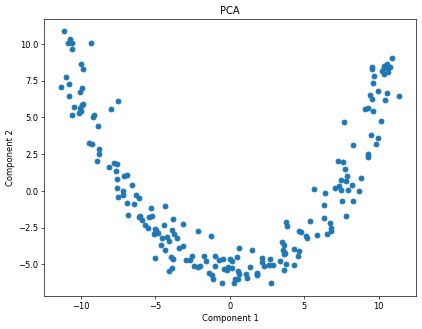

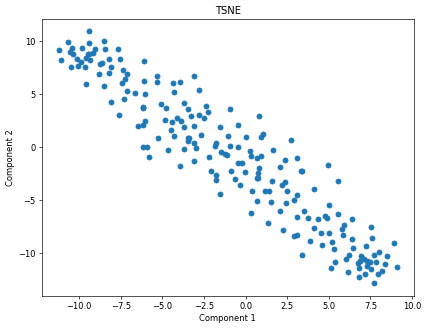

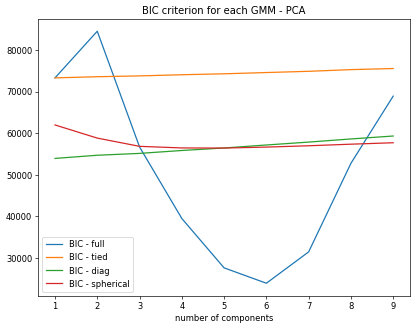

---PCA - Best BIC score: 23907.388634853094 for full mode and for 6 clusters


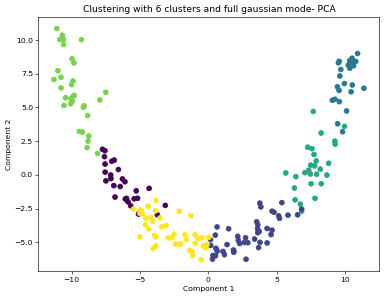

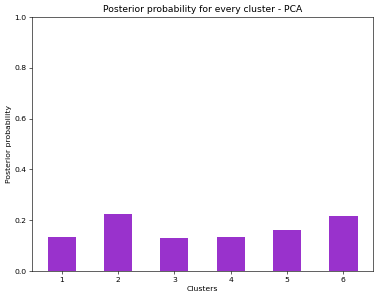

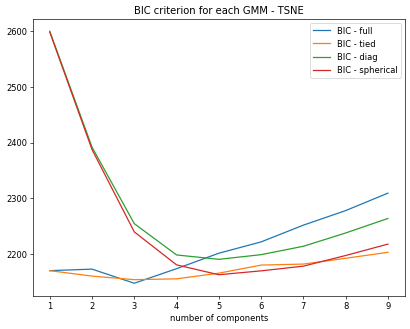

---TSNE - Best BIC score: 2146.967893850508 for full mode and for 3 clusters


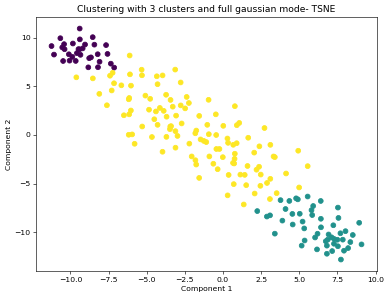

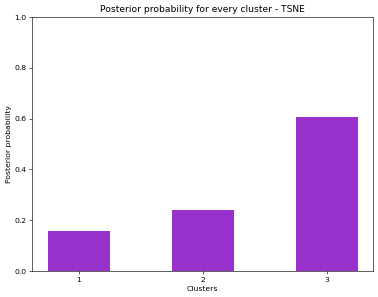

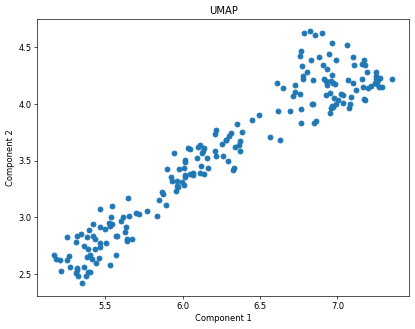

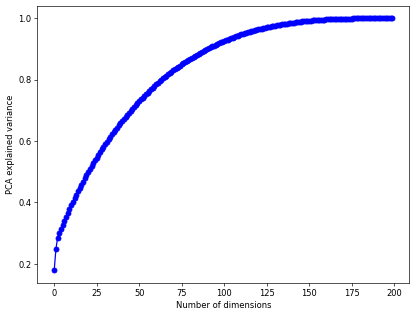

PCA needs 90 components to reach 90.0% of the total variance


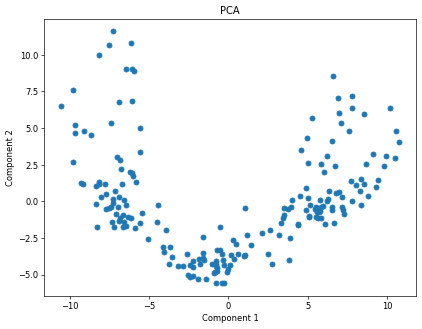

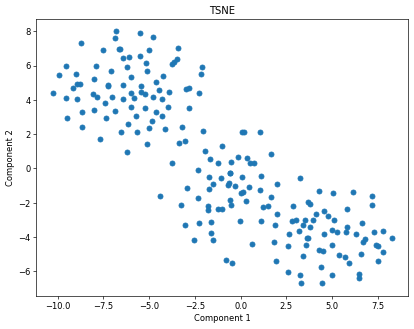

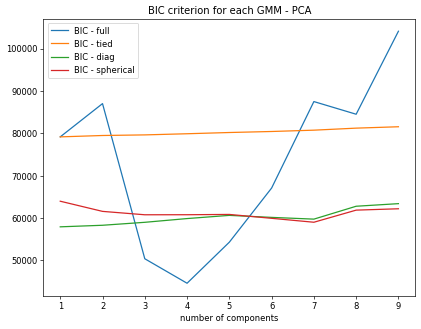

---PCA - Best BIC score: 44635.09418192613 for full mode and for 4 clusters


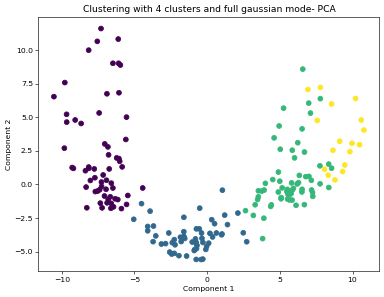

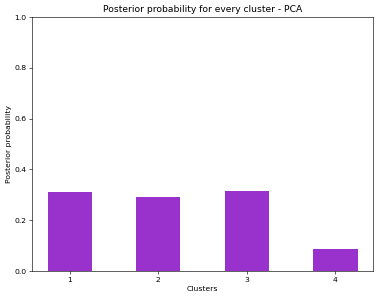

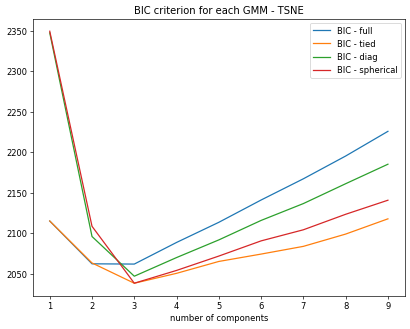

---TSNE - Best BIC score: 2038.2610249608597 for tied mode and for 3 clusters


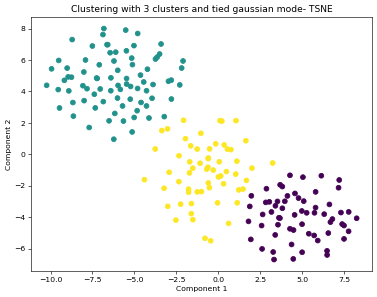

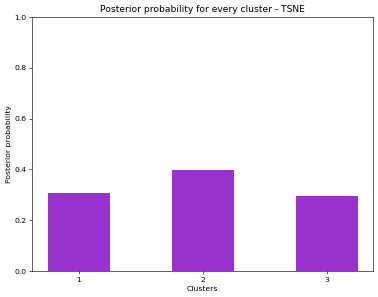

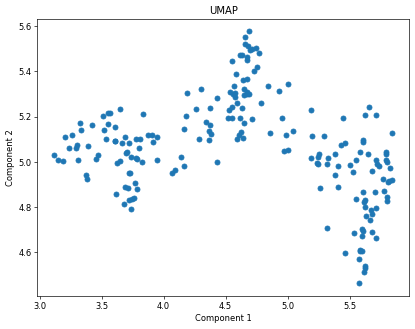

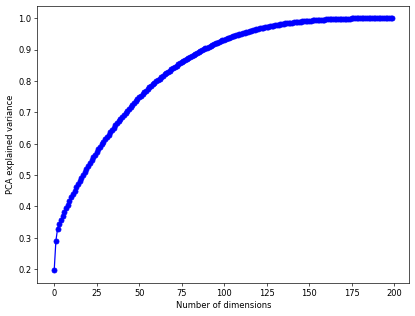

PCA needs 88 components to reach 90.0% of the total variance


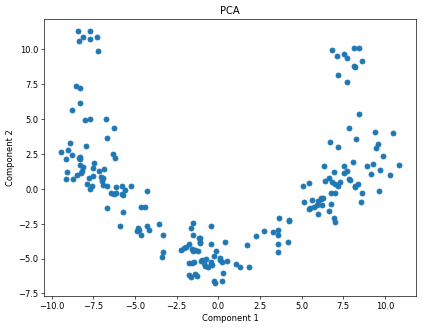

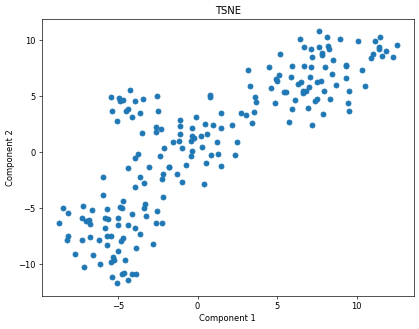

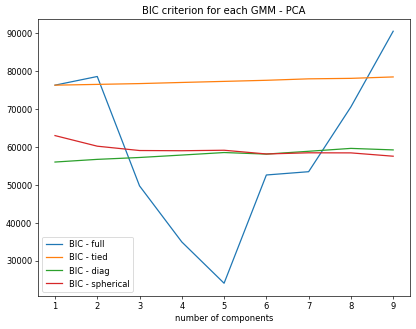

---PCA - Best BIC score: 24026.19121265324 for full mode and for 5 clusters


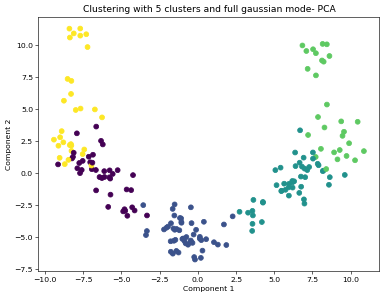

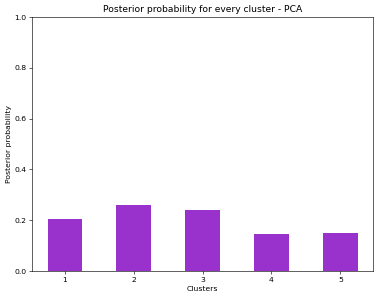

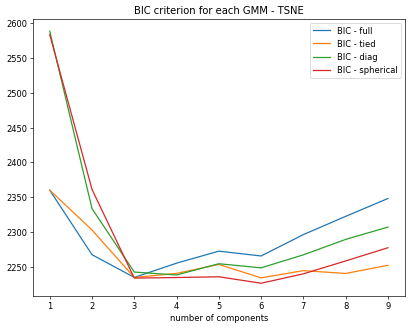

---TSNE - Best BIC score: 2226.3084634793813 for spherical mode and for 6 clusters


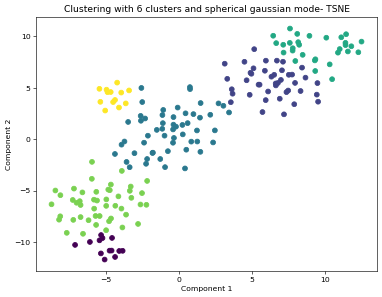

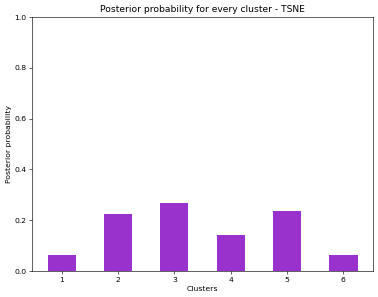

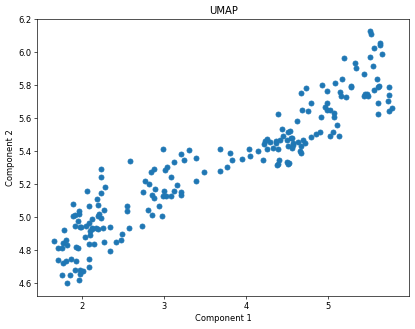

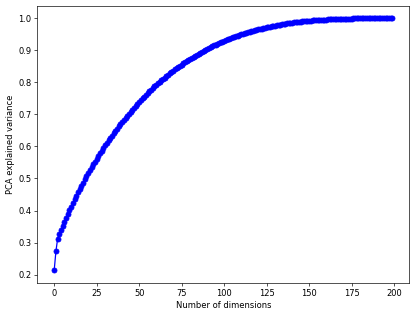

PCA needs 89 components to reach 90.0% of the total variance


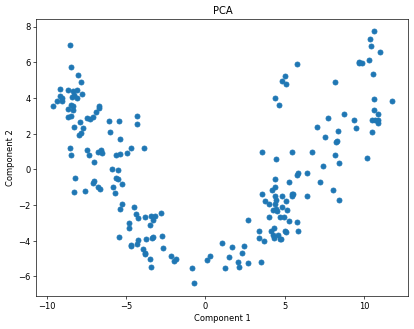

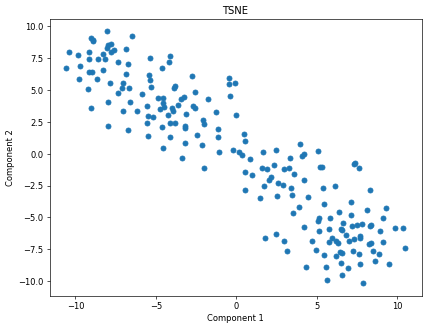

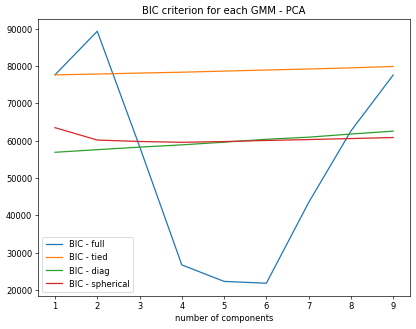

---PCA - Best BIC score: 21816.49384447372 for full mode and for 6 clusters


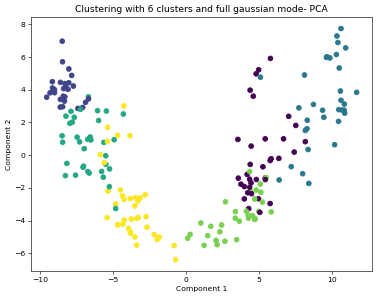

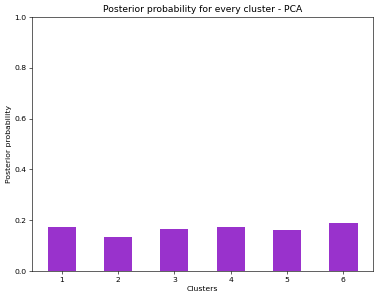

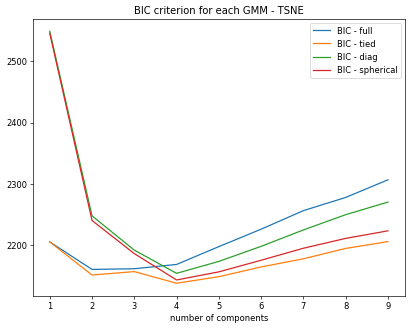

---TSNE - Best BIC score: 2138.5802669036357 for tied mode and for 4 clusters


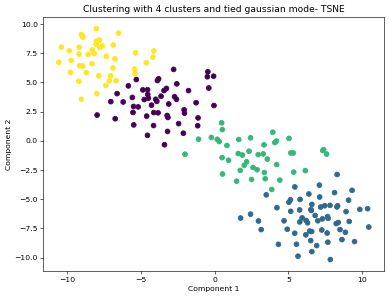

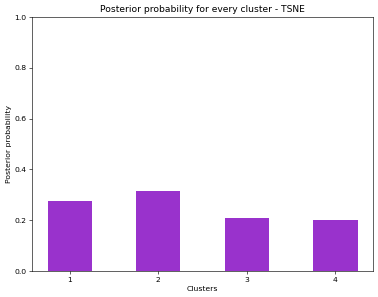

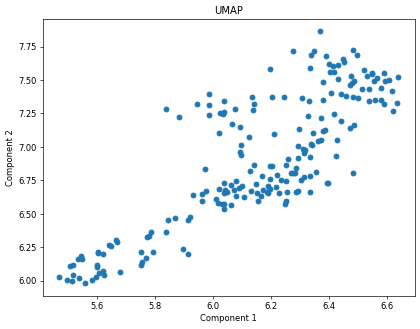

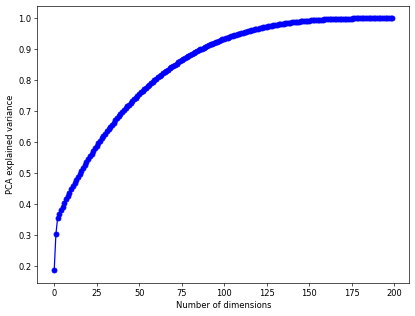

PCA needs 87 components to reach 90.0% of the total variance


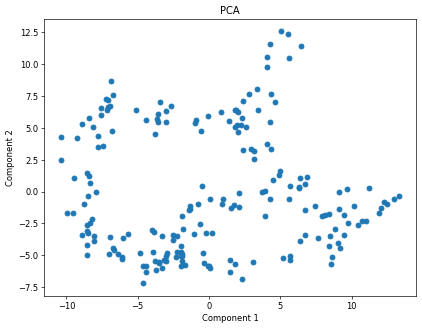

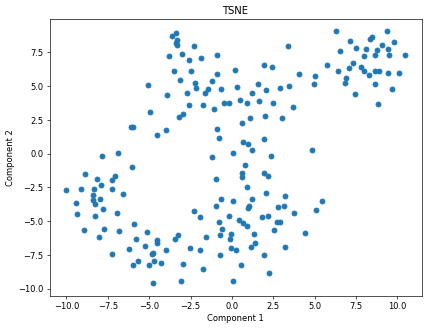

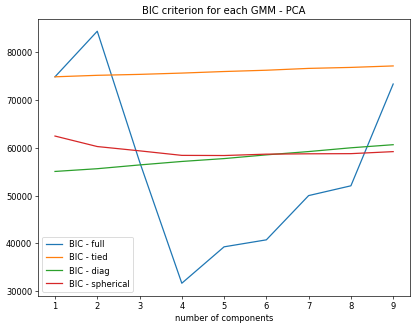

---PCA - Best BIC score: 31656.277891075923 for full mode and for 4 clusters


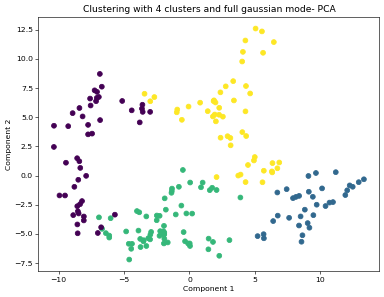

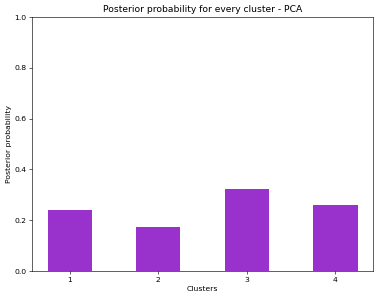

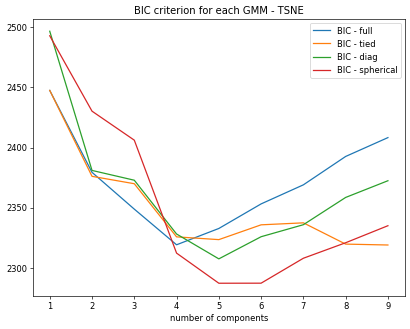

---TSNE - Best BIC score: 2287.0325914067103 for spherical mode and for 5 clusters


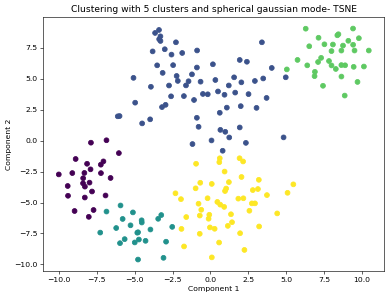

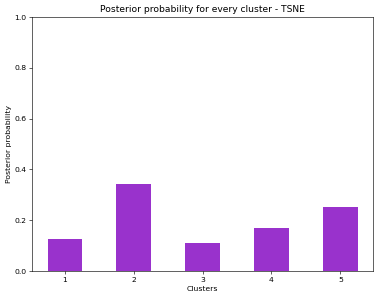

In [78]:
data_list = ['Assignment2_Datasets/dataset1.csv', 'Assignment2_Datasets/dataset2.csv', 'Assignment2_Datasets/dataset3.csv','Assignment2_Datasets/dataset4.csv', 'Assignment2_Datasets/dataset5.csv' ]
counter = 0
for file in data_list :
    counter+=1
    data = pd.read_csv(file)
    scalar = StandardScaler()
    #remove the first column
    data_scaled = pd.DataFrame(scalar.fit_transform(data.loc[:, data.columns != "Unnamed: 0"]), columns=data.loc[:, data.columns != "Unnamed: 0"].columns)
    data_scaled.head()
    umap_components = UMAP_pipeline(data_scaled, counter)
    pca_components, pca_data = PCA_pipeline(data_scaled, counter)
    tsne_data = TSNE_pipeline(pca_data, counter)
    GMM_clustering(pca_data, counter, "PCA")
    GMM_clustering(tsne_data, counter, "TSNE")
